# a45 Unsupervised Learning

# 1. Data Load and Preprocessing

In [8]:
import os
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture


### Load the Heart Disease Data

In [9]:

df_heart = pd.read_csv('/content/sample_data/heart.csv').astype('category')
print("Data has",len(df_heart),"rows and", len(df_heart.columns),"columns.")
if df_heart.isnull().values.any():
    print("Warning: Missing Data")
df_heart.head()

Data has 918 rows and 12 columns.


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [10]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df_heart['Sex'] = label_encoder.fit_transform(df_heart['Sex'])
df_heart['RestingECG'] = label_encoder.fit_transform(df_heart['RestingECG'])
df_heart['ChestPainType'] = label_encoder.fit_transform(df_heart['ChestPainType'])
df_heart['ExerciseAngina'] = label_encoder.fit_transform(df_heart['ExerciseAngina'])
df_heart['ST_Slope'] = label_encoder.fit_transform(df_heart['ST_Slope'])

df_heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [11]:
x = df_heart.drop('HeartDisease', axis=1)
y = df_heart['HeartDisease']

In [122]:
df_heart.to_csv("heart.csv")

### Load the Wine Data

In [12]:
# Read in white wine data 
white = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';')

# Read in red wine data 
red = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')

In [13]:
# Add `type` column to `red` with value 1
red['type'] = 1

# Add `type` column to `white` with value 0
white['type'] = 0


# Append `white` to `red`
df_wines = red.append(white, ignore_index=True)
# df_wines = red
print("Data has",len(df_wines),"rows and", len(df_wines.columns),"columns.")
df_wines.head()

Data has 6497 rows and 13 columns.


<ipython-input-13-b20e5c7aa9c7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wines = red.append(white, ignore_index=True)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [14]:
# Specify the data 
x=df_wines.iloc[:,0:11]
# x=df_wines.iloc[:,0:10]

# Specify the target labels and flatten the array
y= np.ravel(df_wines.type)
# y= df_wines['quality']
y= df_wines.type


In [128]:
df_wines.to_csv("Wines.csv")

# 2. Helper Functions

### Data Loading and Function Prep

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_heart.drop('HeartDisease', axis=1))
    Y1 = np.array(df_heart['HeartDisease'])
    # X1 = np.array(df_heart.values[:,1:-1],dtype='int64')
    # Y1 = np.array(df_heart.values[:,0],dtype='int64')
    # X2 = np.array(df_wines.values[:,1:-1],dtype='int64')
    # Y2 = np.array(df_wines.values[:,0],dtype='int64')
    X2 = np.array(df_wines.iloc[:,0:11])
    Y2= np.array(np.ravel(df_wines.type))
    return X1, Y1, X2, Y2


def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target 
    return pred

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

## Neural Network Classifier

In [130]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(accuracy_score(y_test, y_pred_test))
            f1_train.append(accuracy_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train Accuracy')
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test Accuracy')
    plt.ylabel('Model Accuracy')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    param_grid = {'hidden_layer_sizes': h_units}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',learning_rate_init=0.05,random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes']

# 3. Clustering

## k-Means Clustering

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_kmeans(X,y,title):

    kclusters = list(np.arange(2,50,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []

    for k in kclusters:
        start_time = timeit.default_timer()
        # km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        km = KMeans(n_clusters=k, n_init=10,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        sil_scores.append(sil_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y,km.labels_)
        f1_scores.append(f1_score(y, y_mode_vote))
        # f1_scores.append(f1_score(y, y_mode_vote, average='macro'))
        homo_scores.append(homogeneity_score(y, km.labels_))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
   
    
def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
    auc = roc_auc_score(y, y_mode_vote)
    # auc = roc_auc_score(y, y_mode_vote, multi_class='ovr', average='macro')
    f1 = f1_score(y, y_mode_vote)
    # f1 = f1_score(y, y_mode_vote, average='macro')
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    # precision = precision_score(y, y_mode_vote, average='macro')
    recall = recall_score(y, y_mode_vote)
    # recall = recall_score(y, y_mode_vote, average='macro')
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


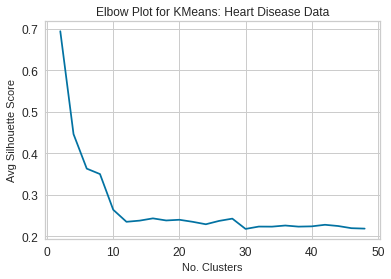

In [135]:
hdX,hdY,wineX,wineY = import_data()
run_kmeans(hdX,hdY,'Heart Disease Data')



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

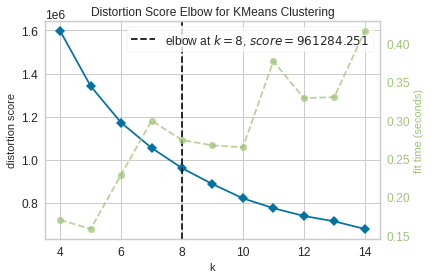

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [133]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
X = hdX

# Instantiate the clustering model and visualizer
model = KMeans()
# visualizer = KElbowVisualizer(model, k=(4,15))
visualizer = KElbowVisualizer(model, k=(4,15))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.47
No. Iterations to Converge: 15
F1 Score:  0.72
Accuracy:  0.69     AUC:       0.69
Precision: 0.73     Recall:    0.72
*****************************************************


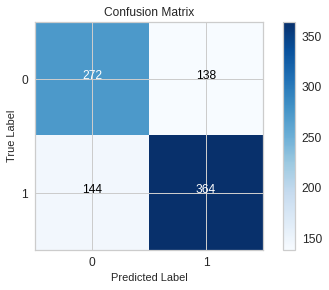

In [136]:
km = KMeans(n_clusters=8,n_init=10,random_state=100)
evaluate_kmeans(km,hdX,hdY)
df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Heart Disease kMeans Cluster Centers.csv")

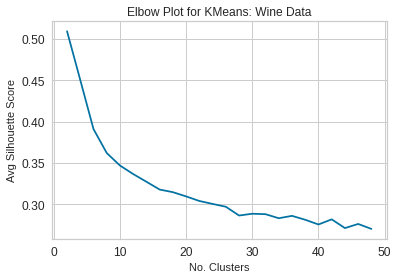

In [138]:
hdX,hdY,wineX,wineY = import_data()
run_kmeans(wineX,wineY,'Wine Data')


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

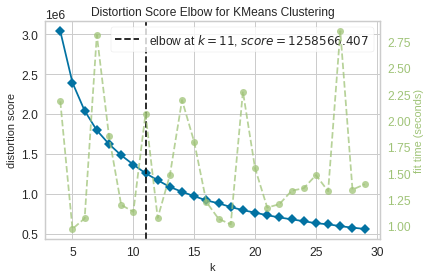

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [139]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
X = wineX

# Instantiate the clustering model and visualizer
model = KMeans()
# visualizer = KElbowVisualizer(model, k=(4,15))
visualizer = KElbowVisualizer(model, k=(4,30))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   4.26
No. Iterations to Converge: 28
F1 Score:  0.84
Accuracy:  0.93     AUC:       0.88
Precision: 0.90     Recall:    0.78
*****************************************************


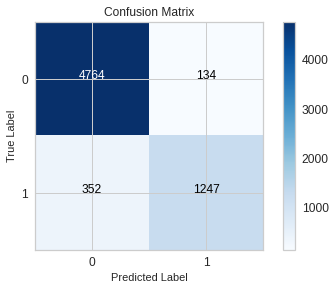

In [140]:
km = KMeans(n_clusters=11,n_init=10,random_state=100)
evaluate_kmeans(km,wineX,wineY)
df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Wine kMeans Cluster Centers.csv")

## Expectation Maximization

In [17]:
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,100,5))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

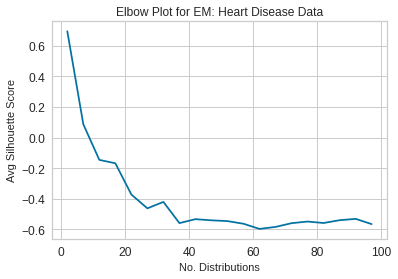

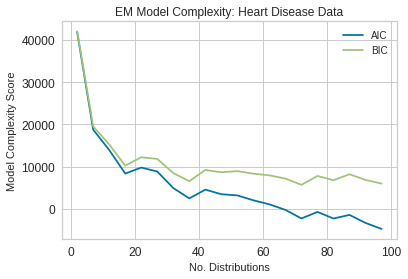

In [144]:
hdX,hdY,wineX,wineY = import_data()
run_EM(hdX,hdY,'Heart Disease Data')


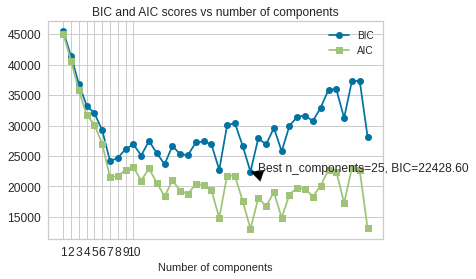

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

def find_best_n_components(X, max_components=130):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = hdX

best_n_components, min_bic_score = find_best_n_components(X)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.18
No. Iterations to Converge: 20
Log-likelihood Lower Bound: -4.95
F1 Score:  0.83
Accuracy:  0.82     AUC:       0.83
Precision: 0.89     Recall:    0.78
*****************************************************


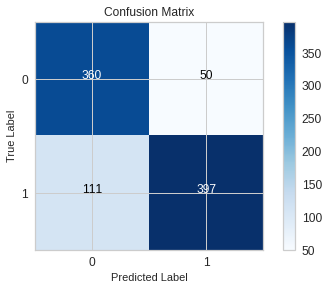

In [164]:
em = EM(n_components=25,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,hdX,hdY)
df = pd.DataFrame(em.means_)
df.to_csv("Heart Disease EM Component Means.csv")

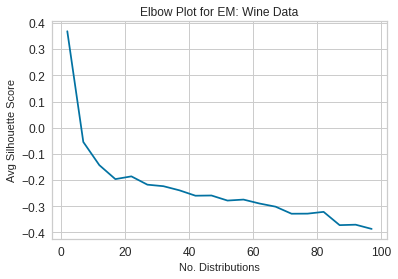

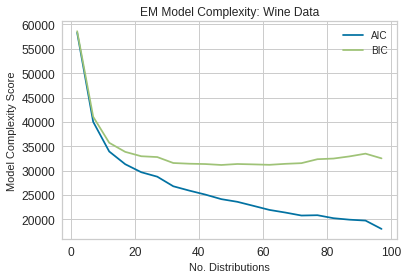

In [165]:
hdX,hdY,wineX,wineY = import_data()
X_train, X_test, y_train, y_test = train_test_split(np.array(wineX),np.array(wineY), test_size=0.25)
run_EM(X_train,y_train,'Wine Data')


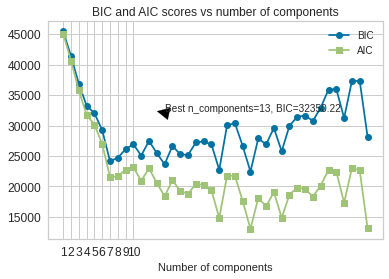

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

def find_best_n_components(X, max_components=20):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = wineX

best_n_components, min_bic_score = find_best_n_components(X)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.42
No. Iterations to Converge: 47
Log-likelihood Lower Bound: -3.45
F1 Score:  0.95
Accuracy:  0.98     AUC:       0.97
Precision: 0.97     Recall:    0.94
*****************************************************


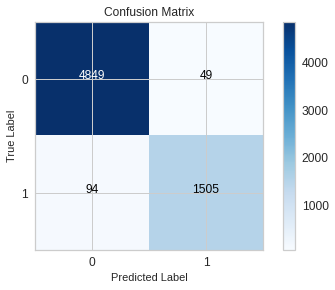

In [167]:
em = EM(n_components=13,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,wineX,wineY)
df = pd.DataFrame(em.means_)
df.to_csv("Wine EM Component Means.csv")


# 4. Dimensionality Reduction

In [18]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=5)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[:-1])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols

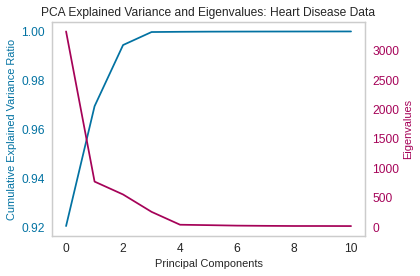

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


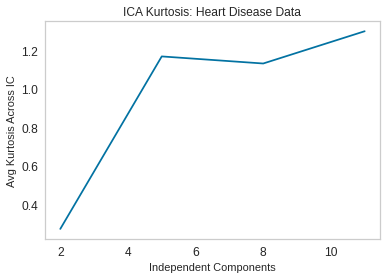

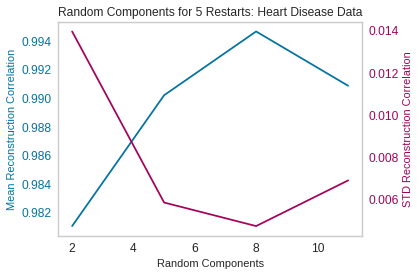

In [19]:
hdX,hdY,wineX,wineY = import_data()
run_PCA(hdX,hdY,"Heart Disease Data")
run_ICA(hdX,hdY,"Heart Disease Data")
run_RCA(hdX,hdY,"Heart Disease Data")
# print(hdX)
# print(hdY)
# df_heart.head()
# hdX.head()

# imp_hdopcols_hd = run_RFC(hdX,hdY,df_heart)

In [21]:
run_RFC(hdX,hdY,df_heart)

(                Feature Importance   Cum Sum
 ST_Slope                  0.306555  0.306555
 ChestPainType             0.176306  0.482860
 ExerciseAngina            0.112395  0.595256
 Oldpeak                   0.107675  0.702931
 Cholesterol               0.080787  0.783718
 MaxHR                     0.079492  0.863210
 Age                       0.041603  0.904814
 Sex                       0.040208  0.945021,
 ['ST_Slope',
  'ChestPainType',
  'ExerciseAngina',
  'Oldpeak',
  'Cholesterol',
  'MaxHR',
  'Age',
  'Sex'])

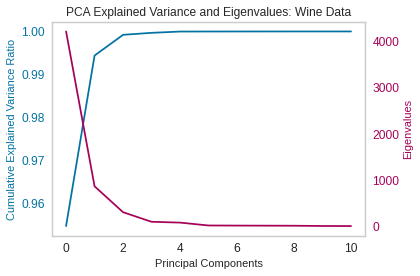

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


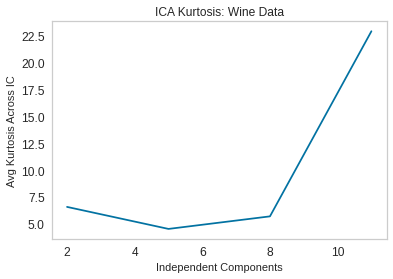

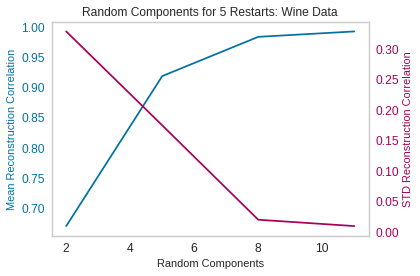

In [170]:
hdX,hdY,wineX,wineY = import_data()
X_train, X_test, y_train, y_test = train_test_split(np.array(wineX),np.array(wineY), test_size=0.2)
run_PCA(X_train,wineY,"Wine Data")
run_ICA(X_train,wineY,"Wine Data")
run_RCA(X_train,wineY,"Wine Data")
imp_wine, topcols_wine = run_RFC(X_train,y_train,df_wines)

Recreating Clustering Experiment (k-means and EM) for Heart Disease data.

In [183]:
#Creating distortion to find the best cluster


def DisVis(X, tuple):
  # Generate synthetic dataset with 8 random clusters
  # X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
  # Instantiate the clustering model and visualizer
  model = KMeans()
  # visualizer = KElbowVisualizer(model, k=(4,15))
  visualizer = KElbowVisualizer(model, k=tuple)

  visualizer.fit(X)        # Fit the data to the visualizer
  visualizer.show()        # Finalize and render the figure

In [179]:
hdX,hdY,wineX,wineY = import_data()
imp_hd, topcols_hd = run_RFC(hdX,hdY,df_heart)
pca_hd = PCA(n_components=3,random_state=5).fit_transform(hdX)
ica_hd = ICA(n_components=5,random_state=5).fit_transform(hdX)
rca_hd = ICA(n_components=5,random_state=5).fit_transform(hdX)
rfc_hd = df_heart[topcols_hd]
rfc_hd = np.array(rfc_hd.values,dtype='int64')

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


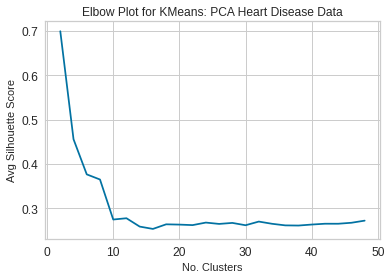

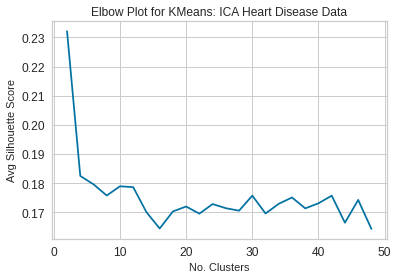

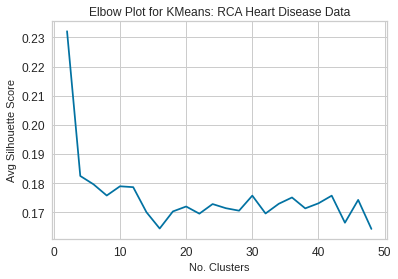

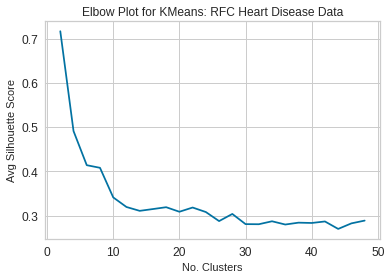

In [180]:
run_kmeans(pca_hd,hdY,'PCA Heart Disease Data')
run_kmeans(ica_hd,hdY,'ICA Heart Disease Data')
run_kmeans(rca_hd,hdY,'RCA Heart Disease Data')
run_kmeans(rfc_hd,hdY,'RFC Heart Disease Data')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

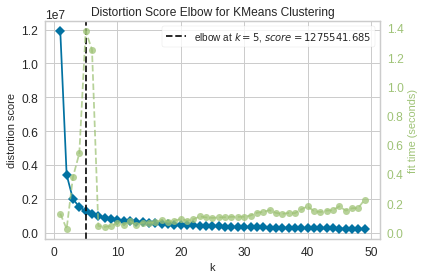

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

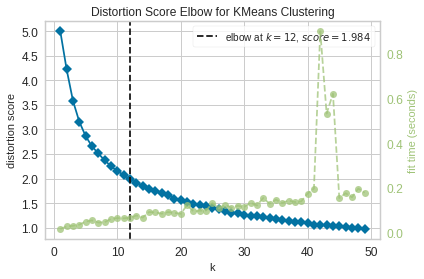

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

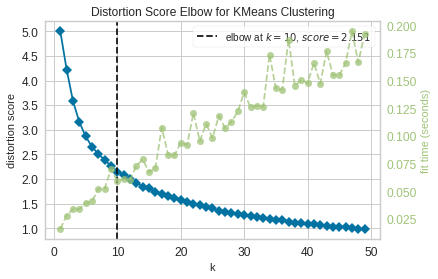

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

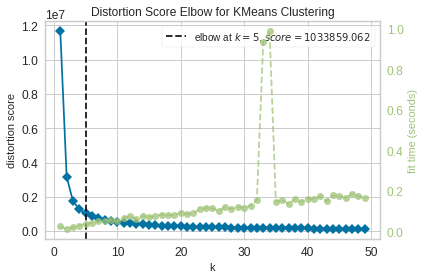

In [187]:
DisVis(pca_hd, (1, 50))
DisVis(ica_hd, (1, 50))
DisVis(rca_hd, (1, 50))
DisVis(rfc_hd, (1, 50))

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.06
No. Iterations to Converge: 12
F1 Score:  0.61
Accuracy:  0.62     AUC:       0.62
Precision: 0.69     Recall:    0.55
*****************************************************


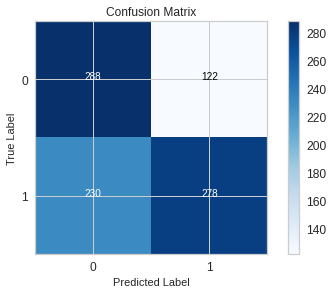

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.09
No. Iterations to Converge: 11
F1 Score:  0.80
Accuracy:  0.78     AUC:       0.79
Precision: 0.82     Recall:    0.78
*****************************************************


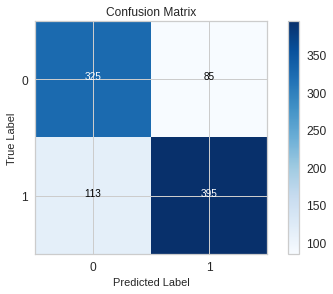

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.95
No. Iterations to Converge: 44
F1 Score:  0.80
Accuracy:  0.79     AUC:       0.80
Precision: 0.85     Recall:    0.75
*****************************************************


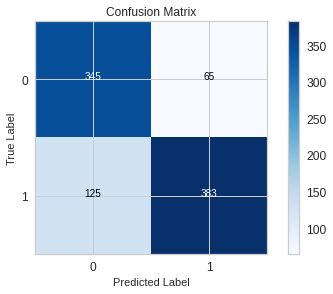

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.22
No. Iterations to Converge: 14
F1 Score:  0.62
Accuracy:  0.62     AUC:       0.62
Precision: 0.69     Recall:    0.56
*****************************************************


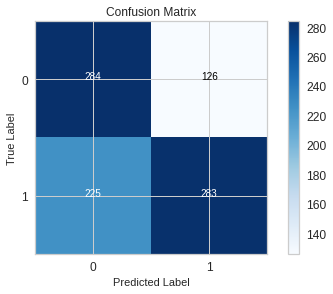

In [199]:
evaluate_kmeans(KMeans(n_clusters=5,n_init=10,random_state=100),pca_hd,hdY)
evaluate_kmeans(KMeans(n_clusters=12,n_init=12,random_state=100),ica_hd,hdY)
evaluate_kmeans(KMeans(n_clusters=10,n_init=10,random_state=100),rca_hd,hdY)
evaluate_kmeans(KMeans(n_clusters=5,n_init=5,random_state=100),rfc_hd,hdY)

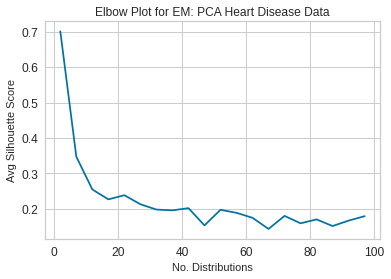

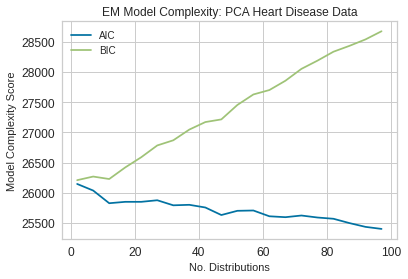

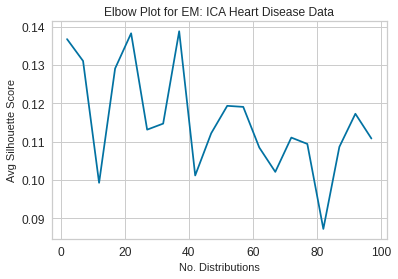

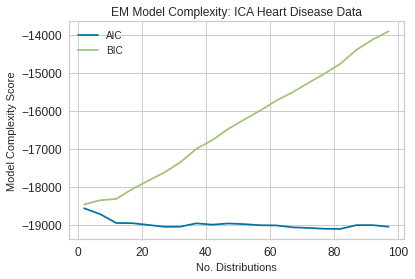

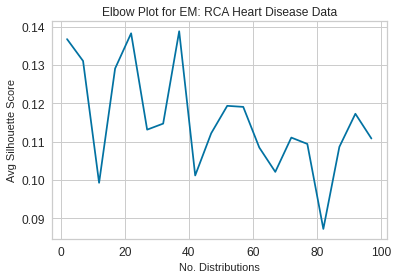

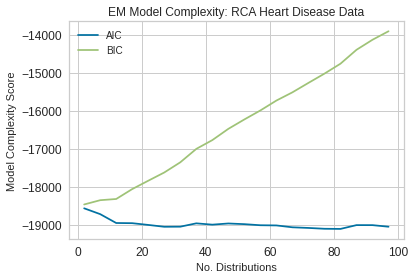

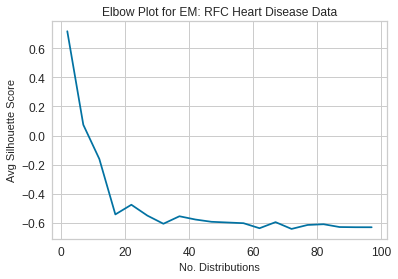

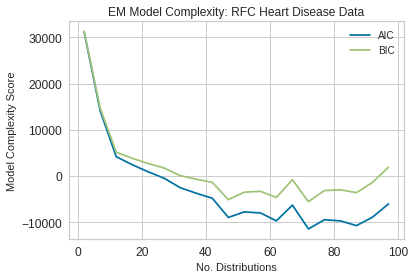

In [200]:
run_EM(pca_hd,hdY,'PCA Heart Disease Data')
run_EM(ica_hd,hdY,'ICA Heart Disease Data')
run_EM(rca_hd,hdY,'RCA Heart Disease Data')
run_EM(rfc_hd,hdY,'RFC Heart Disease Data')

best_n_components 3
min_bic_score 24727.256743302893


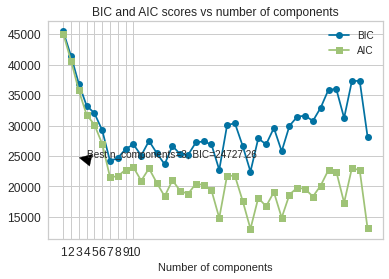

In [233]:
def find_best_n_components(X, max_components=30):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = pca_hd

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


best_n_components 3
min_bic_score -19645.0692938791


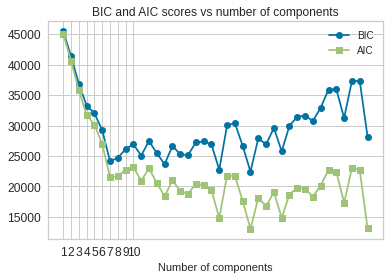

In [232]:
def find_best_n_components(X, max_components=70):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = ica_hd

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


best_n_components 3
min_bic_score -19645.0692938791


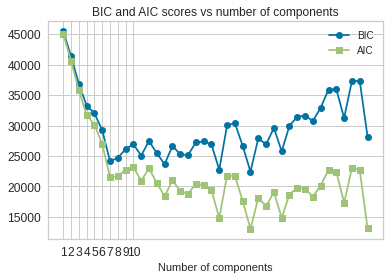

In [230]:
def find_best_n_components(X, max_components=70):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = rca_hd

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
              xy=(best_n_components, min_bic_score), 
              xytext=(best_n_components+1, min_bic_score+50),
              arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


best_n_components 28
min_bic_score 8905.383800764355


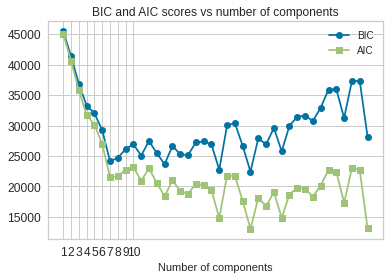

In [231]:
def find_best_n_components(X, max_components=30):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = rfc_hd

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
              xy=(best_n_components, min_bic_score), 
              xytext=(best_n_components+1, min_bic_score+50),
              arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.11
No. Iterations to Converge: 10
Log-likelihood Lower Bound: -14.16
F1 Score:  0.60
Accuracy:  0.64     AUC:       0.66
Precision: 0.78     Recall:    0.49
*****************************************************


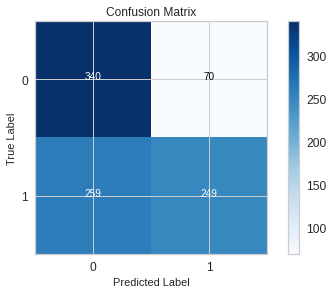

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.02
No. Iterations to Converge: 9
Log-likelihood Lower Bound: 10.16
F1 Score:  0.82
Accuracy:  0.79     AUC:       0.79
Precision: 0.79     Recall:    0.84
*****************************************************


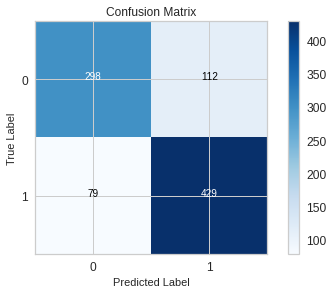

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.47
No. Iterations to Converge: 9
Log-likelihood Lower Bound: 10.16
F1 Score:  0.82
Accuracy:  0.79     AUC:       0.79
Precision: 0.79     Recall:    0.84
*****************************************************


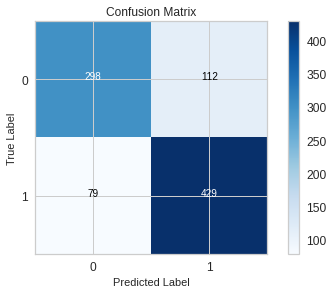

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.11
No. Iterations to Converge: 20
Log-likelihood Lower Bound: 0.73
F1 Score:  0.86
Accuracy:  0.84     AUC:       0.83
Precision: 0.82     Recall:    0.91
*****************************************************


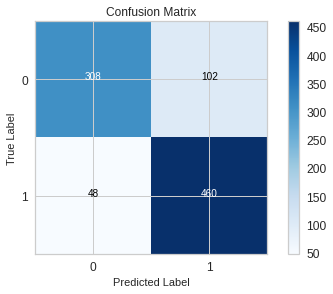

In [235]:

evaluate_EM(EM(n_components=3,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_hd,hdY)
evaluate_EM(EM(n_components=3,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_hd,hdY)
evaluate_EM(EM(n_components=3,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_hd,hdY)
evaluate_EM(EM(n_components=28,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_hd,hdY)

Recreating Clustering Experiment (k-means and EM) for Wine Data.

In [236]:
pca_wine = PCA(n_components= 1,random_state=5).fit_transform(X_train)
ica_wine = ICA(n_components=5,random_state=5).fit_transform(X_train)
rca_wine = ICA(n_components=4,random_state=5).fit_transform(X_train)
rfc_wine = df_wines[topcols_wine]
rfc_wine = np.array(rfc_wine.values,dtype='int64')

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


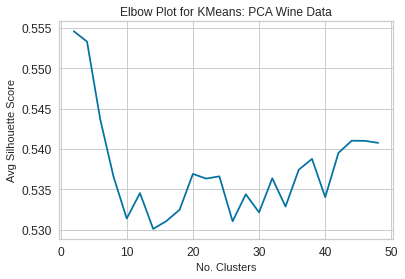

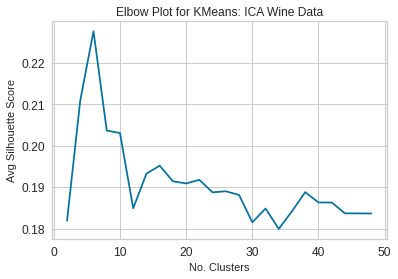

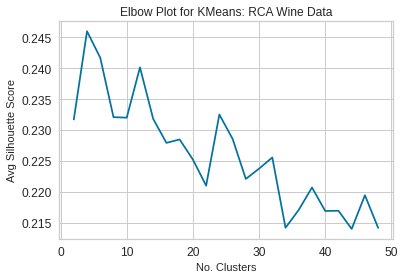

In [243]:
run_kmeans(pca_wine,y_train,'PCA Wine Data')
run_kmeans(ica_wine,y_train,'ICA Wine Data')
run_kmeans(rca_wine,y_train,'RCA Wine Data')
# run_kmeans(rfc_wine,y_train,'RFC Wine Data')

In [252]:
random_array_1 = np.zeros(df_wines.shape[0], dtype=int)
random_array_1[:X_train.shape[0]] = 1
np.random.shuffle(random_array_1)
rfc_wine = df_wines[topcols_wine].iloc[random_array_1 == 1]
rfc_wine = np.array(rfc_wine.values)

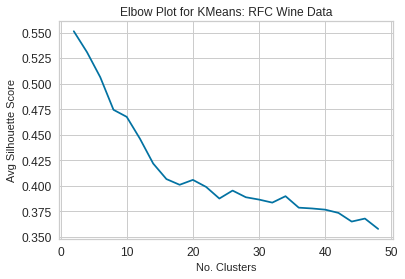

In [253]:
run_kmeans(rfc_wine,y_train,'RFC Wine Data')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

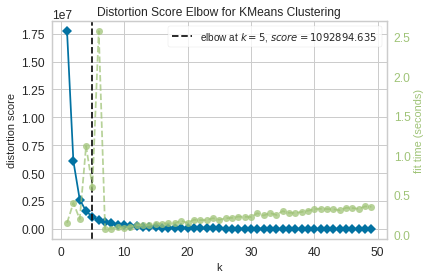

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

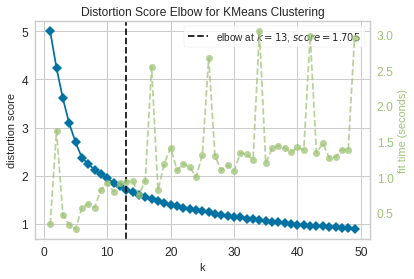

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

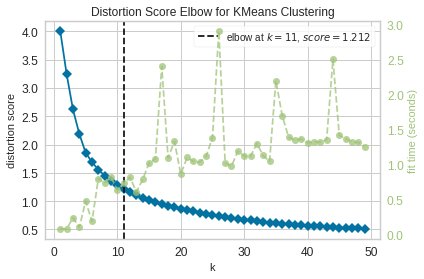

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

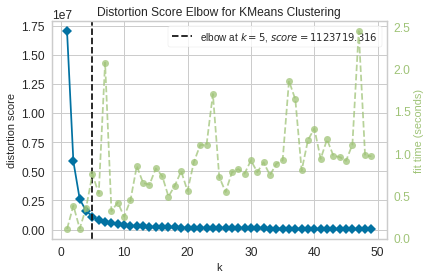

In [254]:
DisVis(pca_wine, (1, 50))
DisVis(ica_wine, (1, 50))
DisVis(rca_wine, (1, 50))
DisVis(rfc_wine, (1, 50))

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.72
No. Iterations to Converge: 5
F1 Score:  0.79
Accuracy:  0.91     AUC:       0.84
Precision: 0.94     Recall:    0.69
*****************************************************


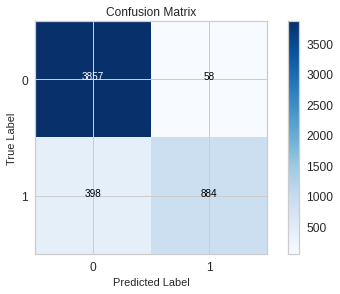

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.43
No. Iterations to Converge: 23
F1 Score:  0.82
Accuracy:  0.92     AUC:       0.87
Precision: 0.87     Recall:    0.77
*****************************************************


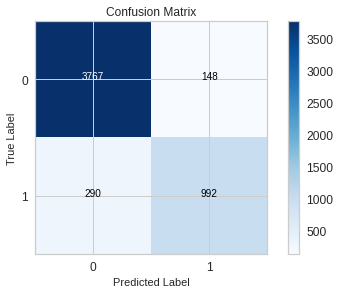

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.19
No. Iterations to Converge: 26
F1 Score:  0.85
Accuracy:  0.93     AUC:       0.88
Precision: 0.90     Recall:    0.79
*****************************************************


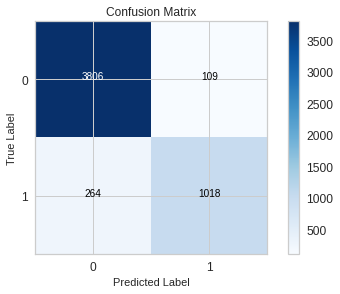

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.62
No. Iterations to Converge: 8
F1 Score:  0.00
Accuracy:  0.75     AUC:       0.50
Precision: 0.00     Recall:    0.00
*****************************************************


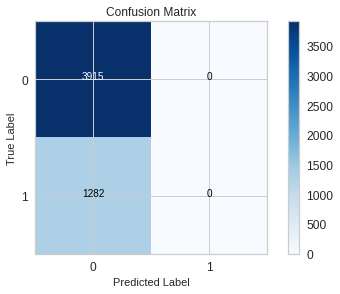

In [256]:
evaluate_kmeans(KMeans(n_clusters=5,n_init=10,random_state=100),pca_wine,y_train)
evaluate_kmeans(KMeans(n_clusters=13,n_init=10,random_state=100),ica_wine,y_train)
evaluate_kmeans(KMeans(n_clusters=11,n_init=10,random_state=100),rca_wine,y_train)
evaluate_kmeans(KMeans(n_clusters=5,n_init=10,random_state=100),rfc_wine,y_train)

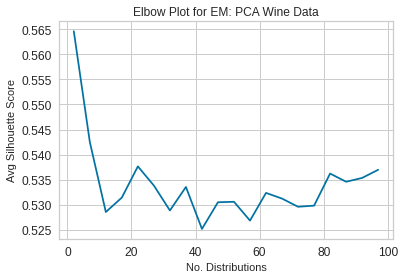

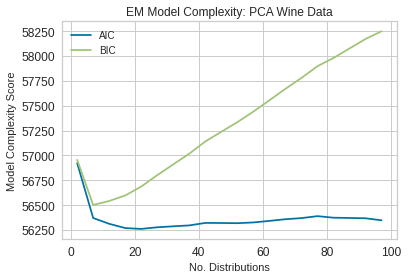

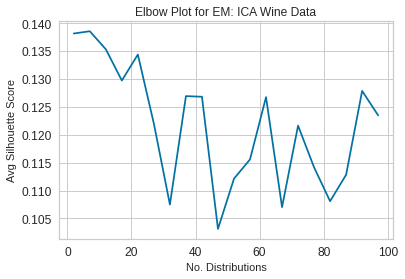

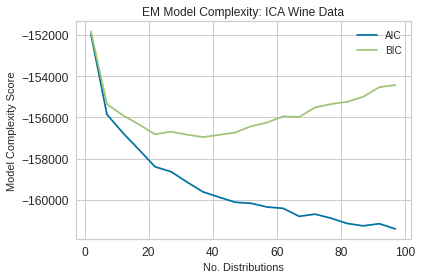

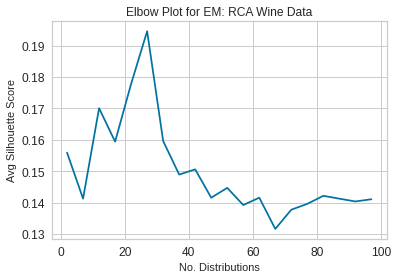

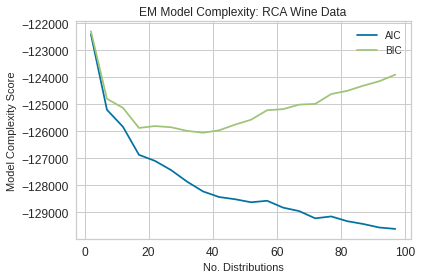

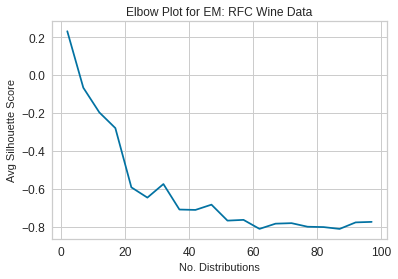

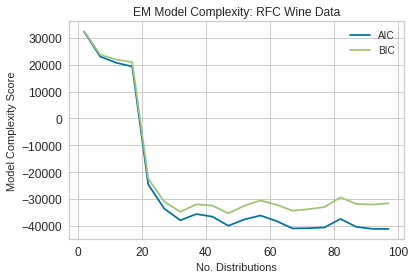

In [264]:
run_EM(pca_wine,y_train,'PCA Wine Data')
run_EM(ica_wine,y_train,'ICA Wine Data')
run_EM(rca_wine,y_train,'RCA Wine Data')
run_EM(rfc_wine,y_train,'RFC Wine Data')

best_n_components 8
min_bic_score 56484.422481054375


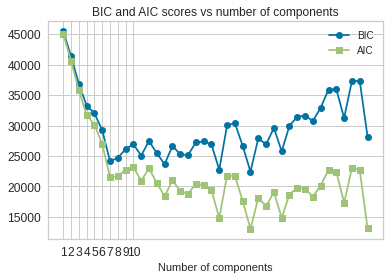

In [265]:
def find_best_n_components(X, max_components=70):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = pca_wine

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


best_n_components 16
min_bic_score -160572.53895844196


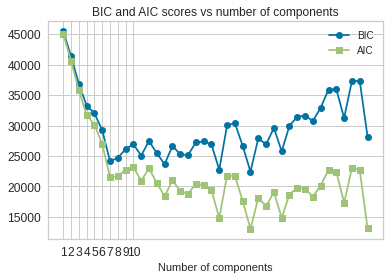

In [266]:
def find_best_n_components(X, max_components=70):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = ica_wine

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


best_n_components 13
min_bic_score -128904.8909123888


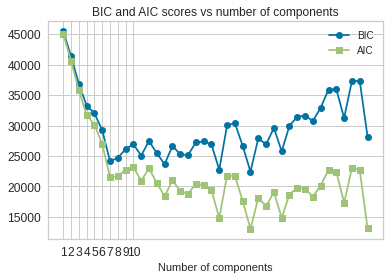

In [267]:
def find_best_n_components(X, max_components=70):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = rca_wine

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


best_n_components 12
min_bic_score -32487.954077899274


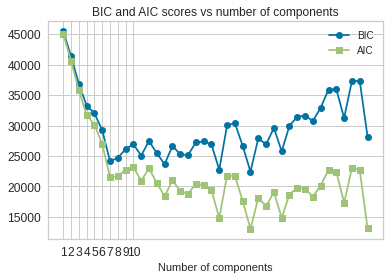

In [268]:
def find_best_n_components(X, max_components=70):
    n_components_range = range(1, max_components+1)
    models = [GaussianMixture(n_components=n, random_state=0).fit(X) for n in n_components_range]
    aic_scores = [model.aic(X) for model in models]
    bic_scores = [model.bic(X) for model in models]
    min_bic_index = np.argmin(bic_scores)
    best_n_components = n_components_range[min_bic_index]
    return best_n_components, min(bic_scores)

# Generate some data for demonstration
X = rfc_wine

best_n_components, min_bic_score = find_best_n_components(X)
print("best_n_components", best_n_components)
print("min_bic_score", min_bic_score)

plt.plot(range(1, len(bic_scores)+1), bic_scores, marker='o', label='BIC')
plt.plot(range(1, len(aic_scores)+1), aic_scores, marker='s', label='AIC')
plt.xticks(range(1, 11))
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.title('BIC and AIC scores vs number of components')
plt.annotate(f'Best n_components={best_n_components}, BIC={min_bic_score:.2f}', 
             xy=(best_n_components, min_bic_score), 
             xytext=(best_n_components+1, min_bic_score+50),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.17
No. Iterations to Converge: 9
Log-likelihood Lower Bound: -5.42
F1 Score:  0.83
Accuracy:  0.92     AUC:       0.89
Precision: 0.83     Recall:    0.83
*****************************************************


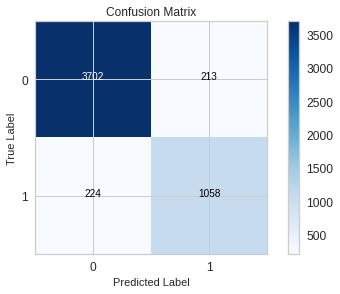

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.55
No. Iterations to Converge: 17
Log-likelihood Lower Bound: 15.15
F1 Score:  0.79
Accuracy:  0.91     AUC:       0.84
Precision: 0.91     Recall:    0.69
*****************************************************


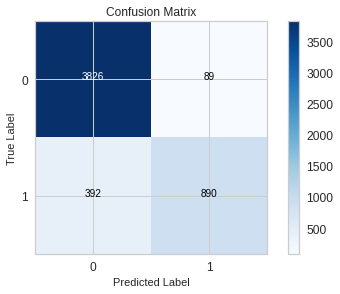

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.88
No. Iterations to Converge: 16
Log-likelihood Lower Bound: 12.13
F1 Score:  0.81
Accuracy:  0.92     AUC:       0.85
Precision: 0.93     Recall:    0.71
*****************************************************


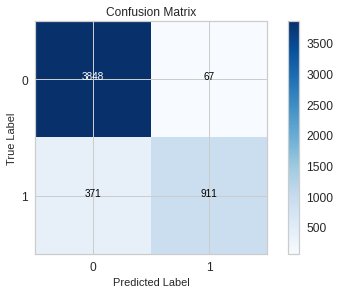

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.58
No. Iterations to Converge: 40
Log-likelihood Lower Bound: -1.96
F1 Score:  0.00
Accuracy:  0.75     AUC:       0.50
Precision: 0.00     Recall:    0.00
*****************************************************


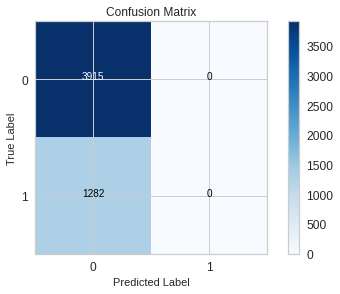

In [274]:
evaluate_EM(EM(n_components=8,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_wine,y_train)
evaluate_EM(EM(n_components=16,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_wine,y_train)
evaluate_EM(EM(n_components=13,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_wine,y_train)
evaluate_EM(EM(n_components=12,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_wine,y_train)

# 5. Training Neural Network on Projected Data

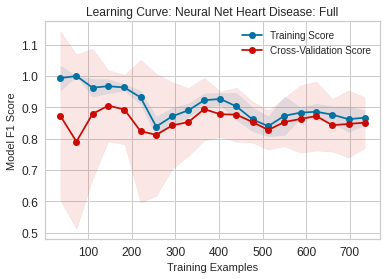

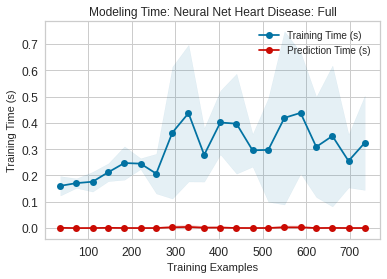

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.34360
Model Prediction Time (s): 0.00083

F1 Score:  0.87
Accuracy:  0.84     AUC:       0.83
Precision: 0.83     Recall:    0.90
*****************************************************


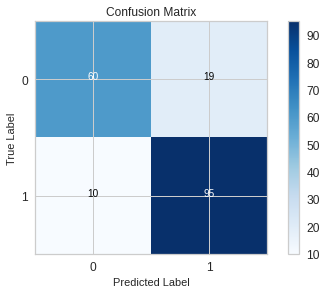

In [275]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(hdX),np.array(hdY), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train, y_train,title="Neural Net Heart Disease: Full")
final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test)

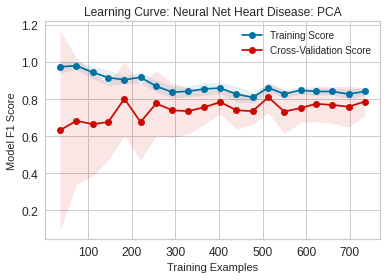

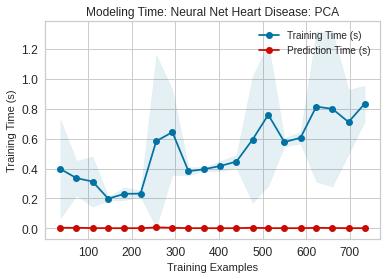

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   2.06134
Model Prediction Time (s): 0.00142

F1 Score:  0.76
Accuracy:  0.73     AUC:       0.72
Precision: 0.72     Recall:    0.80
*****************************************************


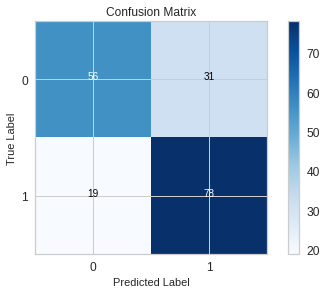

In [276]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pca_hd),np.array(hdY), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Heart Disease: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

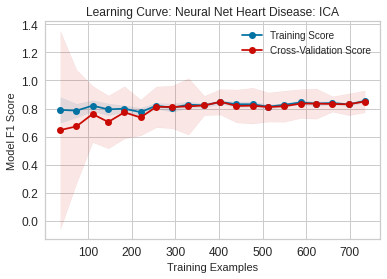

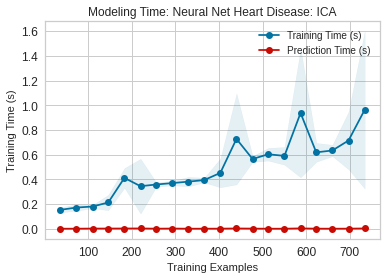

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.63177
Model Prediction Time (s): 0.00067

F1 Score:  0.85
Accuracy:  0.83     AUC:       0.83
Precision: 0.89     Recall:    0.82
*****************************************************


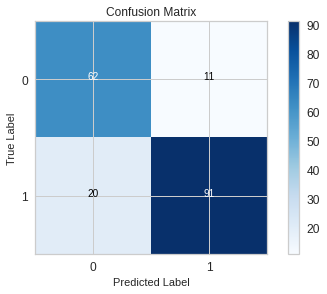

In [277]:
X_train, X_test, y_train, y_test = train_test_split(np.array(ica_hd),np.array(hdY), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Heart Disease: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)

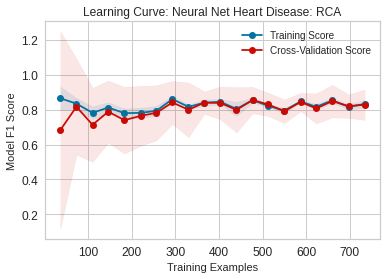

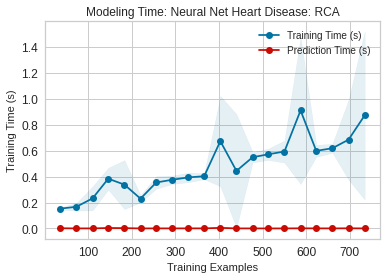

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.66177
Model Prediction Time (s): 0.00073

F1 Score:  0.83
Accuracy:  0.83     AUC:       0.83
Precision: 0.84     Recall:    0.82
*****************************************************


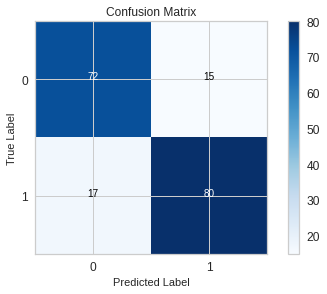

In [278]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rca_hd),np.array(hdY), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Heart Disease: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)

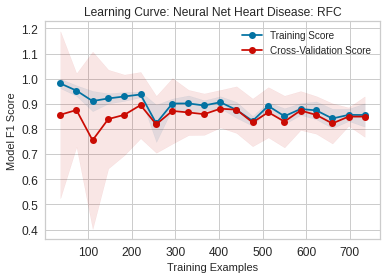

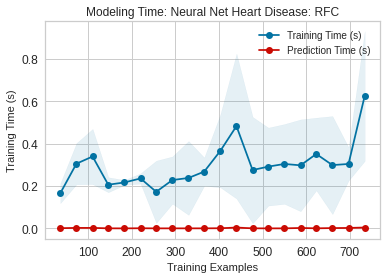

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.47874
Model Prediction Time (s): 0.00068

F1 Score:  0.88
Accuracy:  0.87     AUC:       0.87
Precision: 0.85     Recall:    0.91
*****************************************************


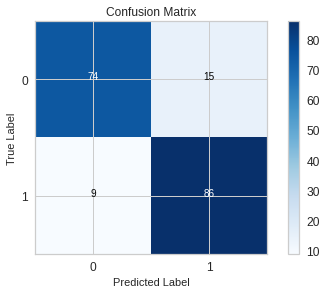

In [279]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rfc_hd),np.array(hdY), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Heart Disease: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)

# 6. Comparison Plots

In [280]:
def compare_fit_time(n,full_fit,pca_fit,ica_fit,rca_fit,rfc_fit,title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, full_fit, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_fit, '-', color="b", label="PCA")
    plt.plot(n, ica_fit, '-', color="r", label="ICA")
    plt.plot(n, rca_fit, '-', color="g", label="RCA")
    plt.plot(n, rfc_fit, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,full_pred, pca_pred, ica_pred, rca_pred, rfc_pred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, full_pred, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_pred, '-', color="b", label="PCA")
    plt.plot(n, ica_pred, '-', color="r", label="ICA")
    plt.plot(n, rca_pred, '-', color="g", label="RCA")
    plt.plot(n, rfc_pred, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,full_learn, pca_learn, ica_learn, rca_learn, rfc_learn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, full_learn, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_learn, '-', color="b", label="PCA")
    plt.plot(n, ica_learn, '-', color="r", label="ICA")
    plt.plot(n, rca_learn, '-', color="g", label="RCA")
    plt.plot(n, rfc_learn, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show() 

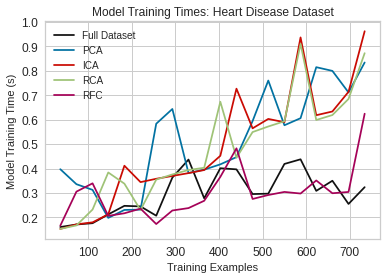

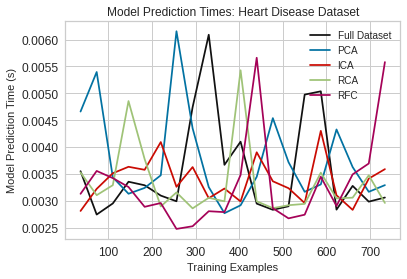

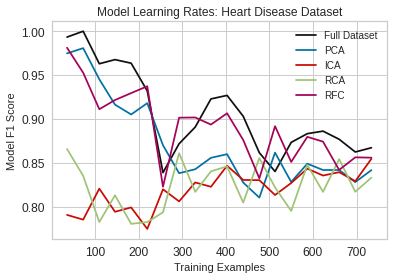

In [281]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Heart Disease Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Heart Disease Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Heart Disease Dataset')  



```
`# This is formatted as code`
```

# 7. Neural Network on Projected Data with Cluster Labels

In [282]:
def addclusters(X,km_lables,em_lables):
    
    df = pd.DataFrame(X)
    df['KM Cluster'] = km_labels
    df['EM Cluster'] = em_labels
    col_1hot = ['KM Cluster', 'EM Cluster']
    df_1hot = df[col_1hot]
    df_1hot = pd.get_dummies(df_1hot).astype('category')
    df_others = df.drop(col_1hot,axis=1)
    df = pd.concat([df_others,df_1hot],axis=1)
    new_X = np.array(df.values,dtype='int64')   
    
    return new_X

In [284]:
km = KMeans(n_clusters=9,n_init=10,random_state=100).fit(hdX)
km_labels = km.labels_
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(hdX)
em_labels = em.predict(hdX)

clust_full = addclusters(hdX,km_labels,em_labels)
clust_pca = addclusters(pca_hd,km_labels,em_labels)
clust_ica = addclusters(ica_hd,km_labels,em_labels)
clust_rca = addclusters(rca_hd,km_labels,em_labels)
clust_rfc = addclusters(rfc_hd,km_labels,em_labels)

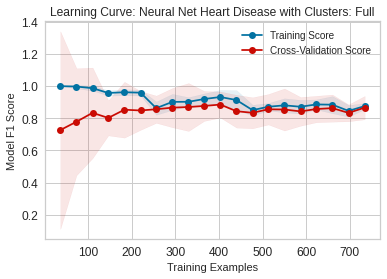

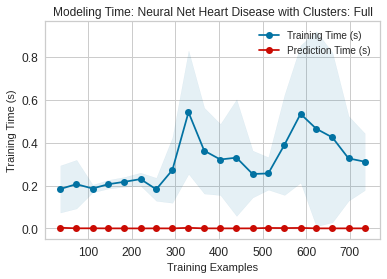

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.54217
Model Prediction Time (s): 0.00062

F1 Score:  0.90
Accuracy:  0.88     AUC:       0.88
Precision: 0.89     Recall:    0.91
*****************************************************


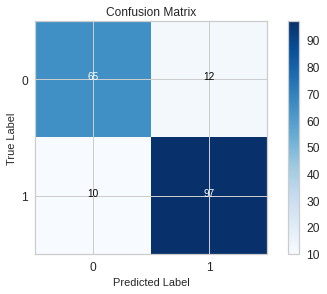

In [285]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_full),np.array(hdY), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train, y_train,title="Neural Net Heart Disease with Clusters: Full")
final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test)

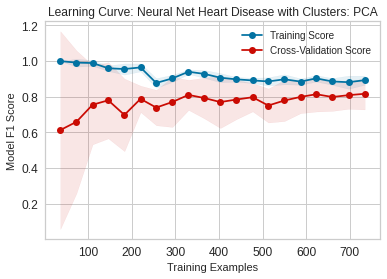

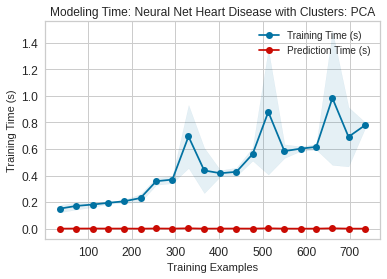

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.83106
Model Prediction Time (s): 0.00140

F1 Score:  0.77
Accuracy:  0.74     AUC:       0.73
Precision: 0.75     Recall:    0.79
*****************************************************


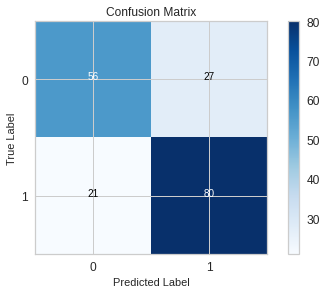

In [286]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_pca),np.array(hdY), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Heart Disease with Clusters: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

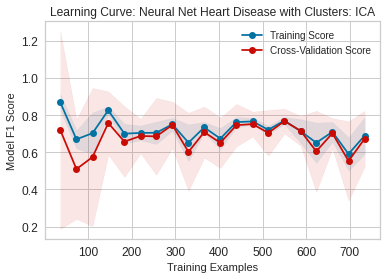

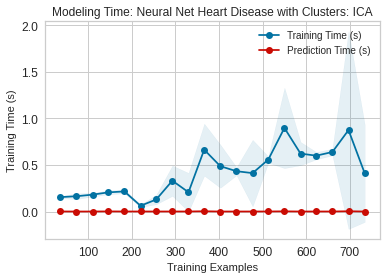

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.80830
Model Prediction Time (s): 0.00144

F1 Score:  0.79
Accuracy:  0.72     AUC:       0.69
Precision: 0.68     Recall:    0.94
*****************************************************


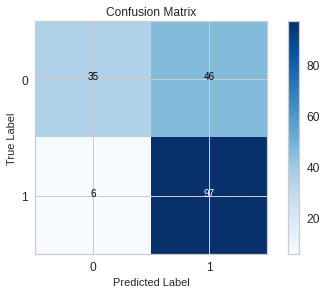

In [287]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_ica),np.array(hdY), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Heart Disease with Clusters: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)

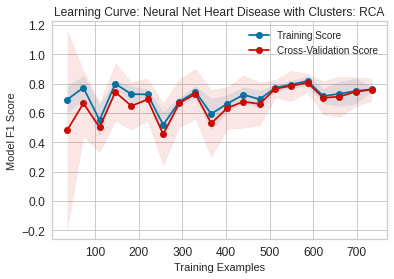

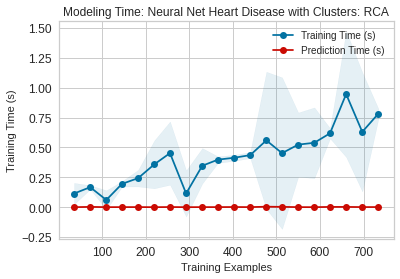

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.79471
Model Prediction Time (s): 0.00153

F1 Score:  0.79
Accuracy:  0.72     AUC:       0.68
Precision: 0.69     Recall:    0.93
*****************************************************


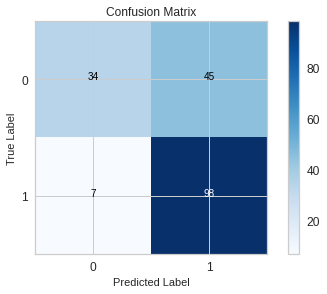

In [288]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rca),np.array(hdY), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Heart Disease with Clusters: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)

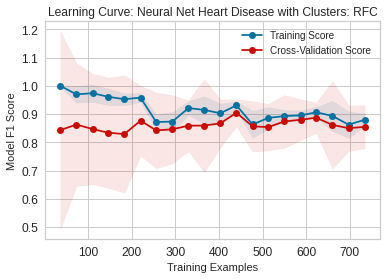

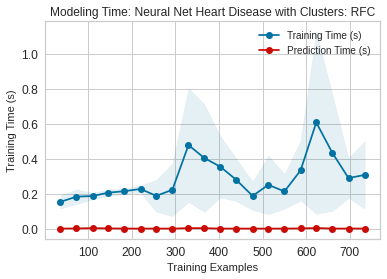

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.22998
Model Prediction Time (s): 0.00057

F1 Score:  0.84
Accuracy:  0.84     AUC:       0.84
Precision: 0.87     Recall:    0.82
*****************************************************


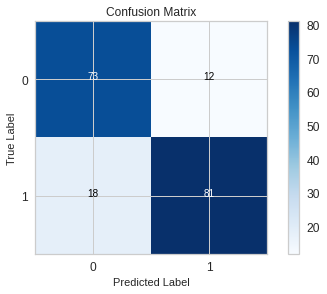

In [289]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rfc),np.array(hdY), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Heart Disease with Clusters: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)

Evaluate new datasets with cluster labels added.

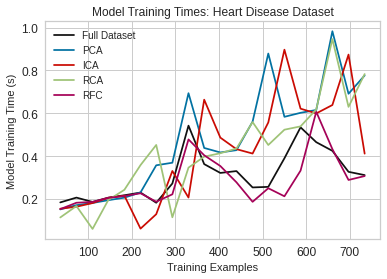

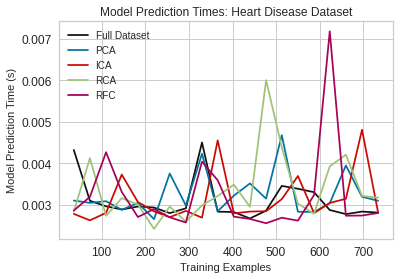

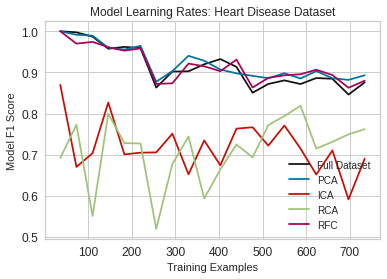

In [290]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Heart Disease Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Heart Disease Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Heart Disease Dataset')  